# Illustrative example of dimension calculation using real data

We plot the dimension of activity and compare to to reciprocal density (measured as rc_over_nodes).  The data was precomputed using `../code/compute_activity_dimension.py`

In [1]:
# General 
import numpy as np
import pandas as pd
from scipy import stats
# Connectomes and network analysis
import conntility
from connalysis.network import local 
# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Specific to this project
import sys 
sys.path.append('../../../library')
from preprocess import load_spike_trains, extract_binned_spike_signals
from dimensionality import get_spectrum_nbds, get_dimensions_nbds, get_dimensions

### Get data 

In [2]:
### Load precomputed data 
root="/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/"
# Load correlations 
fname=f"{root}working_dir/corr_signals_exc.npz"
#fname=f"{root}working_dir/corr_spikes_exc.npz"
corr=np.load(fname)["corr"]
gids=np.load(fname)["gids"]
# Load connectivity matrix
fname=f"{root}working_dir/connectome.h5"
conn=conntility.ConnectivityMatrix.from_h5(fname).index("synapse_class").isin("EXC")
# Check consistency between activity and structure data
assert np.array_equal(conn.gids, gids), "Gids of connectome dont'match with gids of correlations"
# Load spike trains to resolve nans
spikes, _, _ = load_spike_trains(f'{root}/toposample_input/raw_spikes_exc.npy')
t_max=160000
spike_signals, t_bins = extract_binned_spike_signals(spikes, gids, t_max, bin_size=1.0)

In [3]:
# Load dimension and other properties on neighborhoods
props=pd.read_pickle('/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/props_BBP_original.pkl')
dims=pd.read_pickle("/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_signals.pkl")
#dims=pd.read_pickle("/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_spikes.pkl")
props=pd.concat([props, dims],axis=1)
props['normalized_dim']=(props['actitivy_dimension']/props['active_ts']).astype(float)
props["layer"]=conn.vertices["layer"]
thresh=0.01
q=props.quantile(q=0.01)
Q=props.quantile(q=1-0.01)

In [4]:
# Select top and bottom cell of rc_over_nodes to make an example 
base_prop="euclidean_edges_sc" # simplicial complexity
cells={}
cells['high complexity']=props.sort_values(by=base_prop).index[-1]
cells['low complexity']=props.sort_values(by=base_prop).index[0]
# Manual override maximimizing/minimizing efficiency for better visualization of the concept
cells['high complexity']=22351
cells['low complexity']=4363

centers=np.array([x[1] for x in cells.items()])  
# Compute spectrum of both cells 
ss=get_spectrum_nbds(conn, corr, spike_signals, centers=centers,  all_nodes=False, not_firing_corr=False)
df=pd.DataFrame.from_dict(ss, orient="index").T
ss_cum, plot_vals ={}, {}
for cell in ss.keys():
    ss_cum[cell]=np.cumsum(ss[cell])/ss[cell].sum()
    activity_dim,active_ts, _=get_dimensions(ss[cell])
    y=ss_cum[cell][:active_ts]; N=y.size; x=(np.arange(N)+1)/N
    plot_vals[cell]=(x,y, activity_dim, active_ts)

# Getting neighborhood indices
nbd_indices=local.neighborhood_indices(conn.matrix, all_nodes=False, centers=centers)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.74it/s]


In [5]:
# Get top and bottom neighborhoods
props['tribe_sparsity']=np.nan
# Sparse ones
props['tribe_sparsity'][(props[base_prop]<=q[base_prop])]='low complexity'
# Dense ones
props['tribe_sparsity'][(props[base_prop]>=Q[base_prop])]='high complexity'
data=props[np.logical_or(props["tribe_sparsity"]=="high complexity", props["tribe_sparsity"]=="low complexity")]
data["dummy"]=1

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2363245/ipykernel_238122/2020676229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props['tribe_sparsity'][(props[base_prop]<=q[base_prop])]='low complexity'
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2363245/ipykernel_238122/2020676229.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1


### Plotting

In [6]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
#conversion=1.5

marker_size=2
linewidth=2; linewidth_base=1; linestyle_base="dotted"; alpha_base=0.75

# Setting up colors 
colors={
    'high complexity': 'tab:purple', 
    'low complexity': 'tab:cyan', 
    2:matplotlib.colormaps["Set3"](0),
    3:matplotlib.colormaps["Set3"](2),
    4:matplotlib.colormaps["Set3"](5),
    5:matplotlib.colormaps["Set3"](4),
    6:matplotlib.colormaps["Set3"](3)
}
cmaps={}
for key in ['high complexity', 'low complexity']:
    n_bin =  5  # Number of bins to discretizes the interpolation into
    cmap_name = key
    cmaps[key] = LinearSegmentedColormap.from_list(key, ["white", colors[key]], N=n_bin)

In [7]:
# Plotting functions 
def plot_champion_ss(ax, cells, xlog=False, ylog=False):
    for key in cells.keys():
        cell=cells[key]
        x,y, activity_dim, active_ts=plot_vals[cell]
        ax.axhline(0.9,xmax=props.loc[cell]["normalized_dim"]*0.95, color='black', linestyle="dotted")
        ax.axvline(activity_dim/active_ts,ymax=0.87, color=colors[key], linestyle="dashed")
        ax.plot(x,y, label=key, color=colors[key])
        ax.spines[["right", "top"]].set_visible(False)
        if ylog: ax.set_yscale("log")
        if xlog: ax.set_xscale("log")

def plot_correlation_nbd(ax, nbd_indices, cells, complexity_class, log_plot=True, diagonal_out=False):
    center=cells[complexity_class]
    idx=np.append(center, nbd_indices.loc[center])
    corr_sub=corr[np.ix_(idx, idx)] # slice of neighborhood
    mask=~np.all(np.isnan(corr_sub), axis=1) 
    corr_sub=corr_sub[mask][:, mask] # removing non-active submatrix
    sort_id=np.argsort(corr_sub.sum(axis=1)) 
    corr_sub=corr_sub[sort_id][:, sort_id] # sort by total sum across row/col for visualization
    if log_plot: corr_sub=np.log(corr_sub-2*corr_sub.min()) # Logarithmic values for cmap for better visualization
    if diagonal_out: np.fill_diagonal(corr_sub, np.nan) # White space on diagonal
    plot=ax.imshow(corr_sub, cmap=cmaps[complexity_class])
def scatter_and_regress(ax, data, x_col, y_col, color, marker='o', marker_size=marker_size, label=None):
    x=data[x_col]; y=data[y_col] 
    mask=np.logical_and(~np.isnan(y), ~np.isnan(x))
    regress=stats.linregress(x[mask],y[mask])
    ax.plot(x, x*regress.slope+regress.intercept, color=color, label=f"{regress.rvalue:.2f}")
    ax.scatter(x, y, color=color, marker=marker,s=marker_size, label=f"{label}",alpha=0.5, zorder=10, rasterized=True )
    h, l = ax.get_legend_handles_labels()
    return ax, h, l
    

def plot_relation(ax, add_inset=True, marker_size=marker_size):
    x=base_prop; y= "normalized_dim"
    for layer in np.arange(5)+2:
        ax, h, l=scatter_and_regress(ax, props[props["layer"]==layer], x, y, color=colors[layer], marker='o', 
                                    marker_size=marker_size, label=str(layer)) #add alpha
    ax.spines[["right", "top"]].set_visible(False)
    if add_inset:
        left, bottomm, width, height = [0.7, 0.7, 0.3, 0.3]
        ax_inset=ax.inset_axes([left, bottomm, width, height])
        sns.violinplot(data=data, x="dummy", y="normalized_dim", ax=ax_inset,
                       hue="tribe_sparsity", split=True, inner="quart", palette=colors,linewidth=0.001)
        ax_inset.get_legend().remove()
        ax_inset.spines[["left", "top", "bottom"]].set_visible(False)
        ax_inset.yaxis.set_ticks_position("right")
        ax_inset.set_yticks([0.6, 0.9],labels=[0.6, 0.9], fontsize=ticksize)
        ax_inset.set_xticks([])
        ax_inset.set_xlabel('')
        ax_inset.set_ylabel('')
    else:
        ax_inset=None
    return h, l, ax_inset


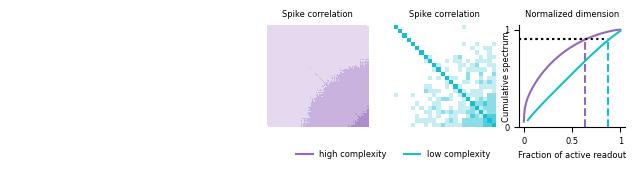

In [8]:
width=21*0.8/conversion
scale_test=1


rows=1; cols=5
fig, axs =plt.subplots(rows,cols,figsize=(width*scale_test*1.2, width*rows*scale_test/cols), sharex=False, sharey=False)


# Correlation matrices 
plot_correlation_nbd(axs[2], nbd_indices, cells, 'high complexity', log_plot=True, diagonal_out=False)
plot_correlation_nbd(axs[3], nbd_indices, cells, 'low complexity', log_plot=True, diagonal_out=False)
axs[2].axis("off")
axs[3].axis("off")
axs[2].set_title("Spike correlation", fontsize=labelsize)
axs[3].set_title("Spike correlation", fontsize=labelsize)


# Spectra
plot_champion_ss(axs[4], cells, xlog=False, ylog=False)
hss, lss=axs[4].get_legend_handles_labels()
axs[4].set_yticks([0,1],labels=[0,1], fontsize=ticksize)
axs[4].set_xticks([0,0.5, 1],labels=[0,0.5, 1], fontsize=ticksize)
axs[4].set_ylabel("Cumulative spectrum", fontsize=labelsize, labelpad=-5)
axs[4].set_xlabel("Fraction of active readout", fontsize=labelsize)
axs[4].set_title("Normalized dimension", fontsize=labelsize)
axs[4].legend(hss, lss, fontsize=labelsize, frameon=False, ncols=2,bbox_to_anchor=(-0.2, -0.15) ) 

axs[0].axis("off")
axs[1].axis("off")



fig.savefig("figs/dimension_nbds_cartoon.pdf", bbox_inches='tight', transparent=True)

Text(0, 0.5, 'Normalized dimension')

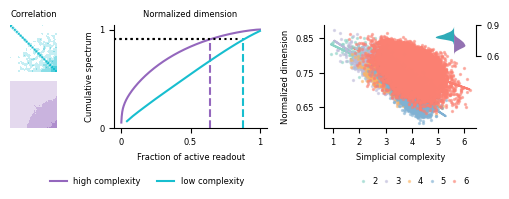

In [9]:
width=15.3/conversion; height=3.4/conversion
fig = plt.figure(figsize=(width, height))
# Make axes
gs = GridSpec(2, 5, figure=fig, wspace=1.2)
ax1 = fig.add_subplot(gs[0, 0]) # Correlations 1
ax2 = fig.add_subplot(gs[1, 0]) # Correlations 2
ax3=fig.add_subplot(gs[:,1:3]) # Spectrum
ax4=fig.add_subplot(gs[:,3:5])

# Correlation matrices 
plot_correlation_nbd(ax1, nbd_indices, cells, 'low complexity', log_plot=True, diagonal_out=False)
plot_correlation_nbd(ax2, nbd_indices, cells, 'high complexity', log_plot=True, diagonal_out=False)
ax1.axis("off")
ax2.axis("off")
ax1.set_title("Correlation", fontsize=labelsize)


# Spectra
plot_champion_ss(ax3, cells, xlog=False, ylog=False)
hss, lss=ax3.get_legend_handles_labels()
ax3.set_yticks([0,1],labels=[0,1], fontsize=ticksize)
ax3.set_xticks([0,0.5, 1],labels=[0,0.5, 1], fontsize=ticksize)
ax3.set_ylabel("Cumulative spectrum", fontsize=labelsize)
ax3.set_xlabel("Fraction of active readout", fontsize=labelsize)
ax3.set_title("Normalized dimension", fontsize=labelsize)
ax3.legend(hss, lss, fontsize=labelsize, frameon=False, ncols=2,bbox_to_anchor=(0.9, -0.4) )  

# Relation and champions
h_reg, l_reg, ax_inset =plot_relation(ax4, add_inset=True)
ax4.legend(h_reg[1::2], l_reg[1::2], frameon=False, fontsize=labelsize, ncols=5, 
           #title="layer", title_fontsize=labelsize,
           columnspacing = .001, handletextpad=0.1,
           bbox_to_anchor=(0.8, -0.5, 0.2, 0.1))
ax4.tick_params(labelsize=labelsize)
ax4.set_yticks([0.65, 0.75, 0.85])
ax4.set_xlabel("Simplicial complexity", fontsize=labelsize)
ax4.set_ylabel("Normalized dimension", fontsize=labelsize)

#plt.tight_layout()
#fig.savefig("figs/dimension_nbds.pdf", bbox_inches='tight', transparent=True) 